In [2]:
from i10_bluesky.devices.rasor.detectorSlits import *
from i10_bluesky.devices.scalerCard import ScaleCard
from i10_bluesky.devices.pimteAD import *
from i10_bluesky.plans.rasor.pimte_plans import AdPlan
from ophyd_async.core import DeviceCollector
from ophyd_async.core.async_status import AsyncStatus
from ophyd_async.core.detector import TriggerInfo, DetectorTrigger
from bluesky.callbacks.best_effort import BestEffortCallback
from bluesky import RunEngine
from bluesky.plans import count, scan  
from bluesky.plan_stubs import *
from bluesky.preprocessors import contingency_wrapper
from ophyd.sim import det1
from bluesky.utils import *
from bluesky.utils import Msg
from bluesky import preprocessors as bpp
from bluesky import plan_stubs as bps
from bluesky.protocols import *
from dodal.beamlines.beamline_utils import set_directory_provider
from ophyd_async.core._providers import StaticDirectoryProvider
import asyncio
import os
loop = asyncio.get_event_loop()
bec = BestEffortCallback()
RE = RunEngine({})


In [3]:
df =  StaticDirectoryProvider("/dls/i10/data/2024/cm37251-2/processing/", "i10-")

with DeviceCollector():
    ds = DetectorSlits('ME01D-MO-APTR',name = "detSlits")
        
pimte = HDFStatsPimte(
"BL10I-EA-PIMTE-01:",
df,
"pimte",)
loop.create_task(pimte.connect())
ti = TriggerInfo(1, DetectorTrigger.internal,6,0.003)

In [18]:
result = loop.create_task(pimte.drv.acquire_time.read())

In [19]:
result
from bluesky.protocols import *

In [4]:
RE(count([pimte]),bec)



Transient Scan ID: 1     Time: 2024-04-08 11:16:00
Persistent Unique Scan ID: 'ef161ace-ad97-4b04-a55e-77979e15e50e'
New stream: 'primary'


/venv/lib/python3.11/site-packages/bluesky/callbacks/core.py:332: UserWarning: The key pimte will be skipped because LiveTable does not know how to display the dtype array
  warnings.warn("The key {} will be skipped because LiveTable "


+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 11:16:04.1 |
+-----------+------------+
generator count ['ef161ace'] (scan num: 1)





('ef161ace-ad97-4b04-a55e-77979e15e50e',)

In [35]:
def imgPlan(devices, name = "primary"):

    devices = separate_devices(devices)  # remove redundant entries
    rewindable = all_safe_rewind(devices)  # if devices can be re-triggered


    def inner_trigger_and_read():
        grp = short_uid('trigger')
        for obj in devices:
            if isinstance(obj, Preparable):
                yield from kickoff(obj, group = grp, wait = True)
                yield from prepare(obj, ti, group=grp, wait = True, )
                yield from complete(obj, group = grp, wait = True)
        # Skip 'wait' if none of the devices implemented a trigger method.
        yield from wait(group=grp)
        yield from create(name)

        def read_plan():
            ret = {}  # collect and return readings to give plan access to them
            for obj in devices:
                reading = (yield from read(obj))
                if reading is not None:
                    ret.update(reading)
            return ret

        def standard_path():
            yield from save()

        def exception_path(exp):
            yield from drop()
            raise exp

        ret = yield from contingency_wrapper(
            read_plan(),
            except_plan=exception_path,
            else_plan=standard_path
        )
        return ret

    from bluesky.preprocessors import rewindable_wrapper
    return (yield from rewindable_wrapper(inner_trigger_and_read(),
                                          rewindable))


In [36]:
def tiggerImg(dets, value):
    yield Msg("set", pimte.drv.acquire_time, value)
    @bpp.stage_decorator([dets])
    @bpp.run_decorator()
    def innerTiggerImg():
        return (yield from imgPlan([dets]))
        #return (yield from bps.trigger_and_read([dets]))
    return (yield from innerTiggerImg())

In [39]:
RE(tiggerImg(pimte,0.004))

('606ed74f-6fed-4a01-8251-cb0efc0ede5b',)

In [46]:
def takeImg2(det,value):
    grp = short_uid('takeImg')
    yield Msg("open_run")
    yield from stage(det)
    yield from kickoff(det, group = grp, wait = True)
    yield from prepare(det, ti, group=grp, wait = True)
    yield from complete(det, group = grp, wait = True)
    yield from wait(group=grp)
    yield Msg("unstage", det)
    yield Msg("close_run")

In [48]:
RE(takeImg2(pimte,ti))

('8086fb13-cb6c-4e31-8124-0b1ba6c3aecf',)

In [13]:
grp = "hoo"
wait(group = grp)

<generator object wait at 0x7fd07de75210>

In [6]:
def tiggerImg3(dets, value):
    yield Msg("set", pimte.drv.acquire_time, value)
    @bpp.stage_decorator([dets])
    @bpp.run_decorator()
    def innerTiggerImg():
        return (yield from bps.trigger_and_read([dets]))
    return (yield from innerTiggerImg())

In [8]:
RE(tiggerImg3(pimte,0.004))

('07ca7b7c-bb00-4178-a816-d8b953b071ac',)

ERROR:bluesky:Run aborted
Traceback (most recent call last):
  File "/venv/lib/python3.11/site-packages/bluesky/run_engine.py", line 1547, in _run
    msg = self._plan_stack[-1].send(resp)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_43109/1191422398.py", line 8, in takeImg2
    return k
           ^
NameError: name 'k' is not defined


NameError: name 'k' is not defined

In [94]:
a

TypeError: 'tuple' object is not callable

In [10]:
RE(takeImg([pimte],1))

('6b6d4507-4f45-4021-b2ac-aa8311a4cb90',)

In [3]:
pimtePlan = AdPlan(pimte)



Transient Scan ID: 1     Time: 2024-04-08 10:56:12
Persistent Unique Scan ID: '9c146069-b83a-481b-b73e-fed49a50d95d'
New stream: 'primary'


/venv/lib/python3.11/site-packages/bluesky/callbacks/best_effort.py:248: UserWarning: Omitting pimte from plot because dtype is array
  warn("Omitting {} from plot because dtype is {}"
/venv/lib/python3.11/site-packages/bluesky/callbacks/core.py:332: UserWarning: The key pimte will be skipped because LiveTable does not know how to display the dtype array
  warnings.warn("The key {} will be skipped because LiveTable "


+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 10:56:15.9 |
+-----------+------------+
generator tiggerImg ['9c146069'] (scan num: 1)





('9c146069-b83a-481b-b73e-fed49a50d95d',)

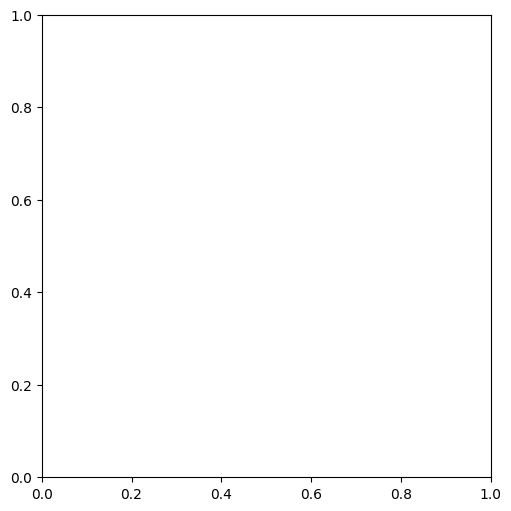

In [4]:
RE(AdPlan.tiggerImg(pimte,0.002),bec)

In [8]:
RE(pimtePlan.takeImg(0.005,2,pimtePlan.det.drv.TriggerMode.internal),bec)



Transient Scan ID: 5     Time: 2024-04-08 10:58:24
Persistent Unique Scan ID: 'ddb19899-7806-460a-8889-52d5c8507401'





('ddb19899-7806-460a-8889-52d5c8507401',)

In [ ]:
RE(pimtePlan.takeImg())

In [ ]:
RE(pimtePlan.takeImg(exposure = 0.003, n_img = 3))

In [ ]:
asyncio.create_task(pimte.writer.open())

In [ ]:
asyncio.wait_for(pimte.trigger(), timeout =10)

In [39]:
async def test():
    aw = await asyncio.gather(pimte.prepare(ti))
    await asyncio.wait_for(aw, timeout = 5)    

In [61]:
asyncio.gather(pimtePlan.setTemp(16))

<_GatheringFuture pending>

In [ ]:
result = asyncio.create_task(test())

In [43]:
print(k)

<_GatheringFuture finished result=[None]>


In [57]:
RE((pimtePlan.setTemp(17)))
RE((pimtePlan.setAdcSpeed(pimte.drv.SpeedMode.adc_200Khz)))

()

In [63]:
def doublePlan():
    yield from pimtePlan.setTemp(19)
    yield from pimtePlan.setAdcSpeed(pimtePlan.det.drv.SpeedMode.adc_2Mhz)

In [64]:
RE(doublePlan())


()

In [70]:
RE(AdPlan.tiggerImg(pimtePlan.det,0.02))

('8e44c418-883f-4688-8484-5bfa9022599b',)